<a href="https://colab.research.google.com/github/MickaRiv/ProjetDatascientest-VoiceSeparator/blob/Stan/notebooks/U_Net-old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs et imports

In [ ]:
!pip install nussl

     |████████████████████████████████| 239 kB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 41.9 MB/s 
     |████████████████████████████████| 240 kB 65.8 MB/s 
     |████████████████████████████████| 146 kB 55.0 MB/s 
     |████████████████████████████████| 310 kB 74.1 MB/s 
     |████████████████████████████████| 51 kB 56 kB/s 
     |████████████████████████████████| 71 kB 213 kB/s 
     |████████████████████████████████| 87 kB 5.2 MB/s 
     |████████████████████████████████| 963 kB 58.7 MB/s 
     |████████████████████████████████| 130 kB 65.2 MB/s 
     |████████████████████████████████| 6.2 MB 19.0 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4710 sha256=71b4c0d8513f79ee702092c14bbc4d1da3c3db0bb509cbbd0c49e60eacc9003d
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=0d66a10ed03db9c86caa75

In [ ]:
!pip install git+https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator

  Cloning https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator to /tmp/pip-req-build-ha6q3oxo
  Running command git clone -q https://github.com/MickaRiv/ProjetDatascientest-VoiceSeparator /tmp/pip-req-build-ha6q3oxo
  Created wheel for voice-separator: filename=voice_separator-0.0.1-py3-none-any.whl size=5583 sha256=9859d363a24635bdb502a9c10021d75bd99d6ab29017396119c1987ab1b704dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-bdn6zs7e/wheels/89/ad/91/9cded351057b1a842fbbfa97f091da426d85036b0efd2e0273
Successfully built voice-separator


In [ ]:
import os
import nussl
import librosa
from matplotlib import pyplot as plt
import numpy as np

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


# Montage du drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Récupération des données

In [ ]:
from voicesep.core import get_musdb_data

path = os.path.join("/content",
                    "drive",
                    "MyDrive",
                    "Projet Datascientest",
                    "musdb18")
musdb = get_musdb_data(gather_accompaniment=True,folder=path)
musdb_train = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="train")
musdb_test = get_musdb_data(gather_accompaniment=True,folder=path,subfolder="test")

Ces variables sont des hooks dataset, et pas directement l'entièreté des données (pour ne pas exploser la RAM). Il est possible d'accéder aux items du dataset par le getitem python classique : `musdb[i]`.

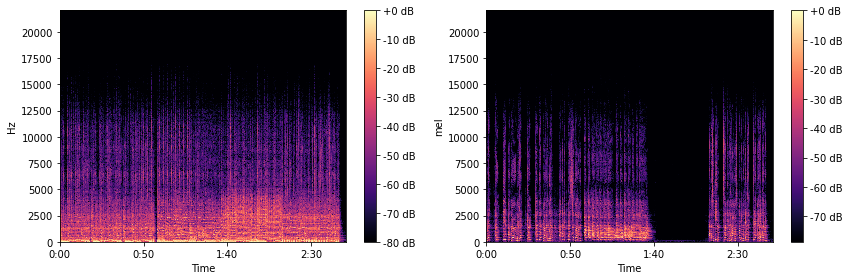

In [ ]:
for i in range(1):
  plt.figure(figsize=(12,4))

  plt.subplot(121)
  nussl.core.utils.visualize_spectrogram(musdb_train[i]['mix'])
  plt.colorbar(format='%+2.0f dB')

  plt.subplot(122)
  nussl.core.utils.visualize_spectrogram(musdb_train[i]['sources']["vocals"])
  plt.colorbar(format='%+2.0f dB')
  plt.ylabel("mel")
  plt.tight_layout()
  plt.show()

# Spectrogrammes et création du dataset

On calcule les spectrogrammes du mix (données d'entrée) et du vocals (ground truth). Les spectres sont concaténés puis découpés pour former une "image" (donnée d'entrée du U-net).
Rem. : faire une fonction, ce serait plus propre

In [ ]:
# paramètres de la STFT
freq        =8192     # fréquence de reéchantillonage

window_length =1023    # taille fenêtre FFT
hop_length    =768     # recouvrement FFT

patch_size = 128      # taille du patch temporel pour le CNN (=128 frames temporels)


npistes=40#len(musdb_train)

k=0
time=0
for npiste in range(npistes):

# Spectro voix et mix
  voice=musdb_train[npiste]['sources']["vocals"]
  mix=musdb_train[npiste]['mix']

  time=time+voice.audio_data.shape[1]/voice.sample_rate 

# Resampling à 8 kHz (pour data plus light)
  voice=librosa.resample(voice.audio_data,voice.sample_rate,freq,res_type='kaiser_fast')
  mix  =librosa.resample(mix.audio_data,mix.sample_rate,freq,res_type='kaiser_fast')
# Passage en mono
  voice = librosa.to_mono(voice)
  mix   = librosa.to_mono(mix)
# fft mix et voix (magnitude normalisée et phase)
  stftvoice = librosa.stft(voice,n_fft=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = librosa.stft(mix,n_fft=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  norm = magmix.max()
  magmix /= norm
  magvoice /= norm

# max  voix en fonctio du temps
  maxtvoice=np.max(magvoice, axis=0)
  maxtvoice=10*np.log(maxtvoice+1e-10)
  db_cutoff=-20
  tmask=np.where(maxtvoice  < db_cutoff, 0, 1)


# concatenation
  k=k+1
  print("processing:",k)
  if (k==1):
    X_mix   =magmix
    X_voice =magvoice
    phase   =phasemix
    h_voice =tmask
  else:
    X_mix  =np.append(X_mix,magmix,axis=1)
    X_voice=np.append(X_voice,magvoice,axis=1)
    phase  =np.append(phase,phasemix,axis=1)
    h_voice =np.append(h_voice,tmask)

nfreq=X_mix.shape[0] 

# split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
nimages=X_mix.shape[1]//patch_size   # nombre total d'images
newsize=nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

print('Data set: ',k, 'songs')
print('Data set: ',time, 'total time (s)')
print('Data set: ',nimages, 'training images with size',nfreq,'x',patch_size)

X_mix_resized  =X_mix  [:,:newsize]
X_voice_resized=X_voice[:,:newsize]
phase_resized=phase[:,:newsize]
h_voice_resized=h_voice[:newsize]

X_mix=np.array(np.split(X_mix_resized, nimages, axis=1))    # découpage 
X_voice=np.array(np.split(X_voice_resized, nimages, axis=1))
phase=np.array(np.split(phase_resized, nimages, axis=1))
h_voice=np.array(np.split(h_voice_resized, nimages))

X_mix=np.expand_dims(X_mix,axis=3) # rajout d'une dimension (canal) 
X_voice=np.expand_dims(X_voice,axis=3)


processing: 1
processing: 2
processing: 3
processing: 4
processing: 5
processing: 6
processing: 7
processing: 8
processing: 9
processing: 10
processing: 11
processing: 12
processing: 13
processing: 14
processing: 15
processing: 16
processing: 17
processing: 18
processing: 19
processing: 20
processing: 21
processing: 22
processing: 23
processing: 24
processing: 25
processing: 26
processing: 27
processing: 28
processing: 29
processing: 30
processing: 31
processing: 32
processing: 33
processing: 34
processing: 35
processing: 36
processing: 37
processing: 38
processing: 39
processing: 40
Data set:  40 songs
Data set:  9607.674195011334 total time (s)
Data set:  800 training images with size 512 x 128


In [ ]:
#idem pour la base de test

npistes=8#len(musdb_train)

k=0
time=0
for npiste in range(npistes):

# Spectro voix et mix
  voice=musdb_test[npiste]['sources']["vocals"]
  mix=musdb_test[npiste]['mix']

# Resampling à 8 kHz (pour data plus light)
  voice=librosa.resample(voice.audio_data,voice.sample_rate,freq,res_type='kaiser_fast')
  mix  =librosa.resample(mix.audio_data,mix.sample_rate,freq,res_type='kaiser_fast')
# Passage en mono
  voice = librosa.to_mono(voice)
  mix   = librosa.to_mono(mix)
# fft mix et voix (magnitude normalisée et phase)
  stftvoice = librosa.stft(voice,n_fft=window_length,hop_length=hop_length)
  magvoice, phasevoice = librosa.magphase(stftvoice)

  stftmix = librosa.stft(mix,n_fft=window_length,hop_length=hop_length)
  magmix, phasemix = librosa.magphase(stftmix)

  norm = magmix.max()
  magmix /= norm
  magvoice /= norm

# max  voix en fonctio du temps
  maxtvoice=np.max(magvoice, axis=0)
  maxtvoice=10*np.log(maxtvoice+1e-10)
  db_cutoff=-20
  tmask=np.where(maxtvoice  < db_cutoff, 0, 1)


# concatenation
  k=k+1
  print("processing:",k)
  if (k==1):
    X_mix_test    =magmix
    X_voice_test  =magvoice
    phase_test    =phasemix
    h_voice_test  =tmask
  else:
    X_mix_test  =np.append(X_mix_test,magmix,axis=1)
    X_voice_test=np.append(X_voice_test,magvoice,axis=1)
    phase_test  =np.append(phase_test,phasemix,axis=1)
    h_voice_test =np.append(h_voice_test,tmask)
 

# split en "images" temporelles de taille patch_size (128 dans le papier d'origine)
nimages=X_mix_test.shape[1]//patch_size   # nombre total d'images
newsize=nimages*patch_size           # nouvelle taille pour un découpage qui tombe juste 

print('Test Data set: ',k, 'songs')
print('Test Data set: ',nimages, 'training images with size',nfreq,'x',patch_size)

X_mix_resized  =X_mix_test  [:,:newsize]
X_voice_resized=X_voice_test[:,:newsize]
phase_resized=phase_test[:,:newsize]
h_voice_resized=h_voice_test[:newsize]

X_mix_test=np.array(np.split(X_mix_resized, nimages, axis=1))    # découpage 
X_voice_test=np.array(np.split(X_voice_resized, nimages, axis=1))
phase_test=np.array(np.split(phase_resized, nimages, axis=1))
h_voice_test=np.array(np.split(h_voice_resized, nimages))

X_mix_test=np.expand_dims(X_mix_test,axis=3) # rajout d'une dimension (canal) 
X_voice_test=np.expand_dims(X_voice_test,axis=3)



processing: 1
processing: 2
processing: 3
processing: 4
processing: 5
processing: 6
processing: 7
processing: 8
Test Data set:  8 songs
Test Data set:  153 training images with size 512 x 128


# Création du U-Net

U-Net tiré de Jansson et al.

Input: "image" de spectrogramme : taille nframes x nfreq
(papier d'origine nframes=128 et nfreq=512)

Output: Mask M (0/1) de même dimension

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Flatten, Dense, Conv2D, Conv2DTranspose , Dropout, Concatenate,  LeakyReLU, ReLU, Activation

# Création de la structure

nframes=patch_size
inputs=Input(shape =(nfreq,nframes,1) )

conv1 = Conv2D(filters = 16, kernel_size = (5,5) , strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(filters = 32, kernel_size = (5,5), strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(filters = 64, kernel_size = (5,5), strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(filters = 128, kernel_size = (5,5), strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(filters = 512, kernel_size = (5,5), strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Conv2DTranspose(filters = 256, kernel_size = (5,5), strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = ReLU()(deconv7)
deconv7 = Concatenate(axis=3)([deconv7, conv5])

deconv8 = Conv2DTranspose(filters = 128, kernel_size = (5,5), strides=2, padding='same')(deconv7)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = ReLU()(deconv8)
deconv8 = Concatenate(axis=3)([deconv8, conv4])

deconv9 = Conv2DTranspose(filters = 64, kernel_size = (5,5), strides=2, padding='same')(deconv8)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = ReLU()(deconv9)
deconv9= Concatenate(axis=3)([deconv9, conv3])

deconv10 = Conv2DTranspose(filters = 32, kernel_size = (5,5), strides=2, padding='same')(deconv9)
deconv10 = BatchNormalization()(deconv10)
deconv10 = ReLU()(deconv10)
deconv10 = Concatenate(axis=3)([deconv10, conv2])

deconv11 = Conv2DTranspose(filters = 16, kernel_size = (5,5), strides=2, padding='same')(deconv10)
deconv11 = BatchNormalization()(deconv11)
deconv11 = ReLU()(deconv11)
deconv11 = Concatenate(axis=3)([deconv11, conv1])

deconv12 = Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=2, padding='same')(deconv11)

mask     = Activation('sigmoid')(deconv12)


output1 = tf.multiply(inputs,mask)


#partie voix (DNN sur espace latent)
flatten = Flatten()
dense1 = Dense(units = 64,activation = 'relu')
dense2 = Dense(units = nframes,activation = 'sigmoid')
x=flatten(conv6)
x=dense1(x)
output2 =dense2(x) 



#je tente un truc de ouf
#output1=tf.multiply(output1,tf.expand_dims(tf.expand_dims(output2,axis=1), axis=1))


#Compilation

#unet = Model(inputs=inputs, outputs=[output1,output2])
unet = Model(inputs=inputs, outputs=output2)

#unet.compile(loss=['mean_absolute_error','binary_crossentropy'],   
#              optimizer='adam',loss_weights=[0.99,0.01])           


es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 15,
                        mode = 'min',
                        restore_best_weights = True)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=10,
                            factor=0.5,
                            verbose=2,
                            mode='min')

unet.compile(loss='binary_crossentropy', optimizer='adam',metrics=[tf.keras.metrics.BinaryAccuracy()])    

#train_history=unet.fit(X_mix,[X_voice,h_voice],


train_history=unet.fit(X_mix,h_voice,
                       validation_split=0.1,
                       epochs=100,
                       batch_size=12,callbacks=[])
 


Epoch 1/100
60/60 [==============================] - 40s 650ms/step - loss: 0.6202 - binary_accuracy: 0.6160 - val_loss: 0.7993 - val_binary_accuracy: 0.6630
Epoch 2/100
60/60 [==============================] - 39s 649ms/step - loss: 0.5598 - binary_accuracy: 0.6656 - val_loss: 0.7201 - val_binary_accuracy: 0.6630
Epoch 3/100
60/60 [==============================] - 39s 648ms/step - loss: 0.5363 - binary_accuracy: 0.6696 - val_loss: 0.7647 - val_binary_accuracy: 0.6603
Epoch 4/100
60/60 [==============================] - 39s 647ms/step - loss: 0.5308 - binary_accuracy: 0.6771 - val_loss: 0.9361 - val_binary_accuracy: 0.6630
Epoch 5/100
60/60 [==============================] - 39s 648ms/step - loss: 0.5074 - binary_accuracy: 0.6912 - val_loss: 1.5692 - val_binary_accuracy: 0.6630
Epoch 6/100
60/60 [==============================] - 39s 647ms/step - loss: 0.5196 - binary_accuracy: 0.6899 - val_loss: 0.7955 - val_binary_accuracy: 0.6630
Epoch 7/100
60/60 [==============================] -

# Evaluations

In [ ]:
# Unet   seul (Ntrain=20 Ntest=8 Batch=8 Epoch=20) =>  loss=0.0018 val_loss=0.0025 
# Hvoice seul (Ntrain=20 Ntest=8 Batch=8 Epoch=20) =>  loss=0.0049 val_loss=1.023  AccTrain=0.97   AccTest=0.68

# combo lossW=0.99/0.01                            => loss=0.020 (0.0019/0.0073) val_loss=0.0127(0.0025/1.03)
#                                                           Separation : MAE=49
#                                                           Hvoice:  AccTrain=0.97   AccTest=0.68

# combo lossW=0.99/0.01 (o2=o1*o2)                 => loss=0.026 (0.0026/0.0049) val_loss=0.0110(0.0025/0.84)
#                                                           Separation : MAE=49
#                                                           Hvoice:  AccTrain=0.97   AccTest=0.68



# Etude de la perfo de la prediction sur Hvoice seul
# ---------------------------------------------------
# 1 couche (128)  Ntrain=20 Ntest=8 Batch=8 Epoch=20 =>   loss=0.0049 val_loss=1.023    AccTest=0.681

# 1 couche (128)  Ntrain=40 Ntest=8 Batch=8 Epoch=20 =>   loss=0.0100 val_loss=1.425   AccTest=0.698
      # idem mais lr=1e-4                                 loss=0.0059 val_loss=0.872   AccTest=0.674
      # idem mais Batch=16                                loss=0.0047 val_loss=1.065   AccTest=0.696
      #callbacks                                          loss=0.0035 val_loss=0.930   AccTest=0.696
      #CONV5                                              loss=0.0023 val_loss=0.98   AccTest=0.671

      # 2couches (100epoch,BS=12)                          loss=0.28 val_loss=0.75    AccTest=0.703



#perfo prédiction de voix
# accuracy score de la prédiction de voix (0/1)

from sklearn.metrics import accuracy_score

#ytest =unet.predict(X_mix.reshape(-1,nfreq,nframes,1))
#ypred=ytest[1].flatten()
#yclass=np.where(ypred > 0.5, 1, 0 )
#ytrue=h_voice.flatten()
#print('Acc(Train)',accuracy_score(yclass.round(),ytrue))

ytest =unet.predict(X_mix_test.reshape(-1,nfreq,nframes,1))
#ypred=ytest[1].flatten()
ypred=ytest.flatten()
yclass=np.where(ypred > 0.5, 1, 0 )
ytrue=h_voice_test.flatten()
print('Acc(Test)',accuracy_score(yclass.round(),ytrue))



Acc(Test) 0.7034824346405228


True voice


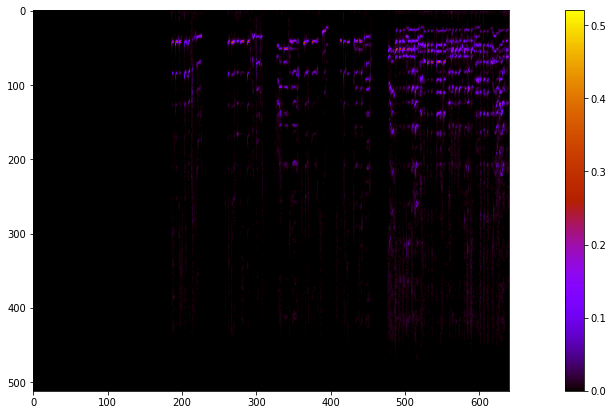

Predicted voice


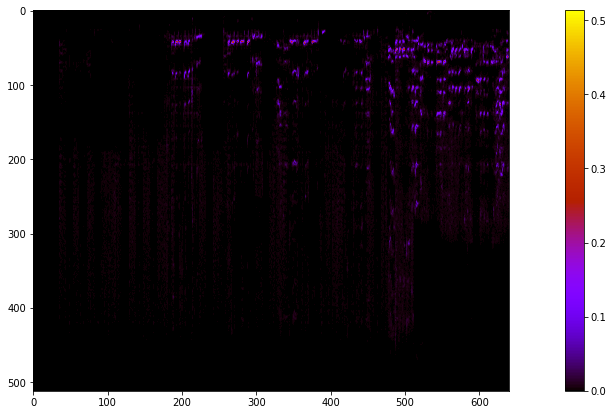

MAE 49.745266155763325


In [ ]:
# perfo séparation

print(X_voice_test.shape)
 
print('MAE',abs(ytest-X_voice_test).sum()/mix_to_plot.shape[1])

print("True voice")
plt.figure(figsize=(16,7))
plt.subplot(121)
mix_to_plot = np.concatenate([X_voice_test[i] for i in range(5)],axis=1)
plt.imshow(mix_to_plot[:,:,0],cmap="gnuplot")
plt.colorbar()
plt.show()

ytest = unet.predict(X_mix_test.reshape(-1,nfreq,nframes,1))[0]
print("Predicted voice")
plt.subplot(122)
mix_to_plot = np.concatenate([ytest[i] for i in range(5)],axis=1)
plt.imshow(mix_to_plot[:,:,0],cmap="gnuplot")
plt.colorbar()
plt.show()
